In [1]:
%load_ext autoreload
%autoreload 2

import io
import os
import sys
import IPython.display
import PIL.Image
from pprint import pformat
import matplotlib.pyplot as plt

import numpy as np

#import tensorflow as tf2

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

dir2 = os.path.abspath('..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import h5py
from pathlib import Path

inversion_results_path ='X:\\Results\\Neurophysical-Data-Decoding\\BigGan-Inversions\\0983c26d-808e-4503-ae52-51a1174906a2'
root = 'X:\\Datasets\\Deep-Image-Reconstruction'

biggan_inversions = h5py.File(Path(inversion_results_path) / 'kamitani_stimulus_inversion.hdf5', 'r')
stimulus_images = h5py.File(Path(root) / "derivatives" / "stimulus_images.hdf5", "r")

In [3]:
model_name = 'biggan-128'
version = 2
module_path = f'https://tfhub.dev/deepmind/{model_name}/{version}'

module = hub.Module(module_path)
input_info = module.get_input_info_dict('default')
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}
output = module(inputs)

for signature in module.get_signature_names():
    print('Signature:', signature)
    print('Inputs:', pformat(module.get_input_info_dict(signature)))
    print('Outputs:', pformat(module.get_output_info_dict(signature)))
    print()
    
input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']

dim_z = input_z.shape.as_list()[1]
vocab_size = input_y.shape.as_list()[1]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Signature: default
Inputs: {'truncation': <hub.ParsedTensorInfo shape=() dtype=float32 is_sparse=False>,
 'y': <hub.ParsedTensorInfo shape=(?, 1000) dtype=float32 is_sparse=False>,
 'z': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>}
Outputs: {'default': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>}



In [4]:
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

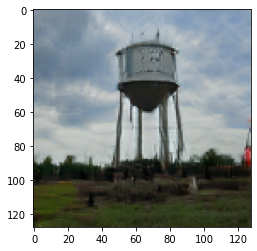

In [5]:
# Sampling

from scipy.stats import truncnorm

z = truncnorm.rvs(-2, 2, size=(1, 120),)# random_state=state)
y = np.zeros(shape=(1, 1000))
y[:, 900] = 1.

feed_dict = {input_z: z, input_y: y, input_trunc: 1.}
image = sess.run(output, feed_dict=feed_dict)
plt.imshow(image[0] * 0.5 + 0.5)

In [8]:
graph = tf.get_default_graph()
variables = graph.get_collection('variables', scope=None)
embedding_matrix, embedding_matrix_ema = [
    var.eval(session=sess) for var in variables
    if var.shape == (1000, 128)
]

embedding_matrix_pinv = np.linalg.pinv(embedding_matrix)
embedding_matrix_ema_pinv = np.linalg.pinv(embedding_matrix_ema)

In [28]:
Y = biggan_inversions['ytrain'][:]
embed = Y @ embedding_matrix
Y_inv = embed @ embedding_matrix_pinv

re_embed = Y_inv @ embedding_matrix

2.785393e-08

In [54]:
from ipywidgets import interact
import torch

index_map = {stimulus_id: i for i, stimulus_id in enumerate(stimulus_images.keys())}
graph = tf.get_default_graph()

@interact(stimulus_id=stimulus_images.keys())
def show(stimulus_id):
    i = index_map[stimulus_id]
    
    z = biggan_inversions['encoding'][i]
    y = biggan_inversions['ytrain'][i]
    x = biggan_inversions['xtrain'][i]
    
    linear_module = graph.get_operation_by_name('module/linear/MatMul')
    linear = linear_module.outputs[0]
    
    feed_dict = {input_z: z[None], input_y: y[None], input_trunc: 1.}
    x_reconstruction = sess.run(output, feed_dict=feed_dict)
    
    x_reconstruction = x_reconstruction[0] * 0.5 + 0.5
    x = np.moveaxis(x, 0, -1) / 255
    
    print(x.shape, x_reconstruction.shape)
    
    out = np.concatenate([x, x_reconstruction], axis=1)
    plt.imshow(out)
    
    print(i, stimulus_id)

interactive(children=(Dropdown(description='stimulus_id', options=('11978233.016933', '11978233.018962', '1197…

In [70]:
#with h5py.File(Path(root) / "derivatives" / "biggan-128-features.hdf5", "w") as f:
for i, stimulus_id in enumerate(stimulus_images.keys()):
    z = biggan_inversions['encoding'][i]
    y = biggan_inversions['ytrain'][i]
    y_embedding =  y @ embedding_matrix
    y_embedding_ema = y @ embedding_matrix_ema
    
    #print(y_embedding.shape, y_embedding.mean(), y_embedding.std())
    continue
    stimulus = f.create_group(stimulus_id)
    stimulus['z'] = z
    stimulus['y'] = y
    stimulus['y_embedding'] = y_embedding
    stimulus['y_embedding_ema'] = y_embedding_ema

In [295]:
from scipy import ndimage, misc
import h5py
from pathlib import Path

stimulus_ids = ['1443537.022563', '1621127.019020', '1677366.018182', '1846331.017038', '1858441.011077', '1943899.024131', '1976957.013223', '2071294.046212', 
                '2128385.020264', '2139199.010398', '2190790.015121', '2274259.024319', '2416519.012793', '2437136.012836', '2437971.005013', '2690373.007713', 
                '2797295.015411', '2824058.018729', '2882301.014188', '2916179.024850', '2950256.022949', '2951358.023759', '3064758.038750', '3122295.031279', 
                '3124170.013920', '3237416.058334', '3272010.011001', '3345837.012501', '3379051.008496', '3452741.024622', '3455488.028622', '3482252.022530', 
                '3495258.009895', '3584254.005040', '3626115.019498', '3710193.022225', '3716966.028524', '3761084.043533', '3767745.000109', '3941684.021672', 
                '3954393.010038', '4210120.009062', '4252077.010859', '4254777.016338', '4297750.025624', '4387400.016693', '4507155.021299', '4533802.019479', 
                '4554684.053399', '4572121.003262']

y_embedding_pred = np.load('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\biggan-128__y_embedding__sub-03__test-prediction__v3.npy')
y_embedding_target = np.load('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\biggan-128__y_embedding__sub-03__test__v3.npy')
z_pred = np.load('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\biggan-128__z__sub-03__test-prediction__v3.npy')
z_target = np.load('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\biggan-128__z__sub-03__test__v3.npy')

y_embedding_pred = y_embedding_pred
y_pred = y_embedding_pred @ embedding_matrix_pinv
y_target = y_embedding_target @ embedding_matrix_pinv

indices = y_pred.argsort(axis=1)
#y_pred = np.zeros((50, 1000))

#num_classes = 5
#scales = [0.5, 0.25, 0.1, 0.1, 0.5]'

#for i in range(num_classes):
    #y_pred[np.arange(50), indices[:, -(i+1)]] = 1. / num_classes

x_stim = []
for stimulus_id in stimulus_ids:
    x = stimulus_images[stimulus_id]['data'][:]
    x = ndimage.zoom(x, (128 / 500, 128 / 500, 1))
    x = x / 256 * 2 - 1
    x_stim.append(x)
x_stim = np.stack(x_stim)


x_target = np.concatenate([
    sess.run(output, feed_dict={input_z: z[None], input_y: y[None], input_trunc: 1.}) 
    for z, y in zip(list(z_target), list(y_target))
])

z_scale = z_target.std() / z_pred.std()
y_scale = y_target.std() / y_pred.std()
x_pred = np.concatenate([
    sess.run(output, feed_dict={input_z: z[None] * z_scale, input_y: y[None] * y_scale, input_trunc: 1.}) 
    for z, y in zip(list(z_pred), list(y_pred))
])

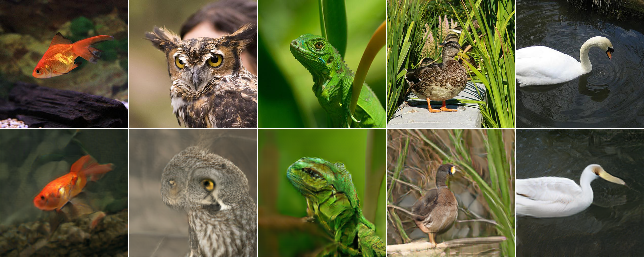

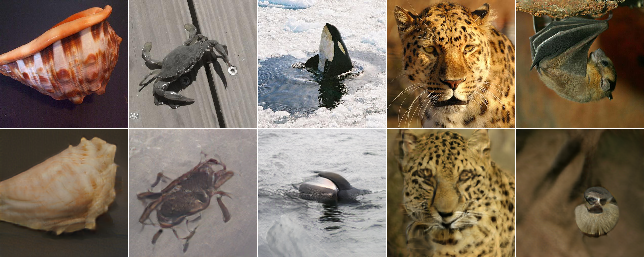

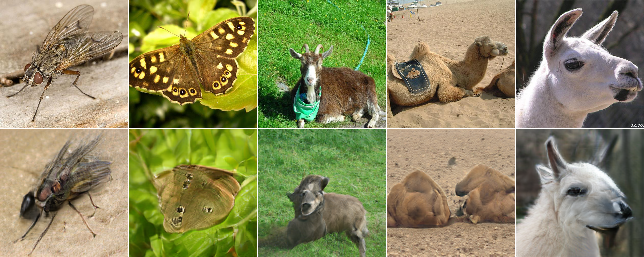

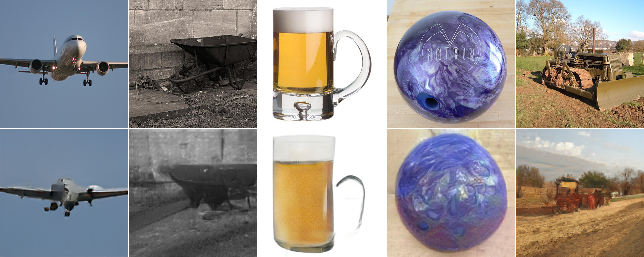

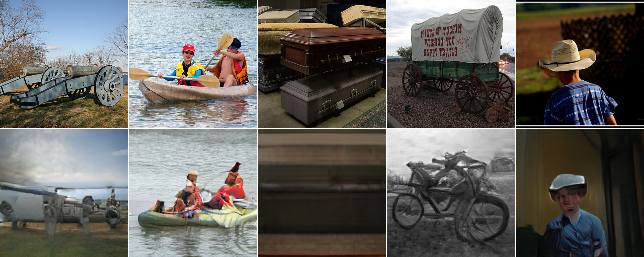

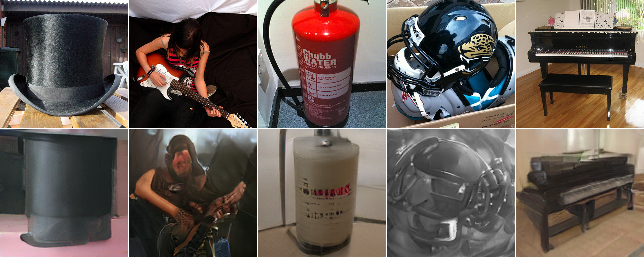

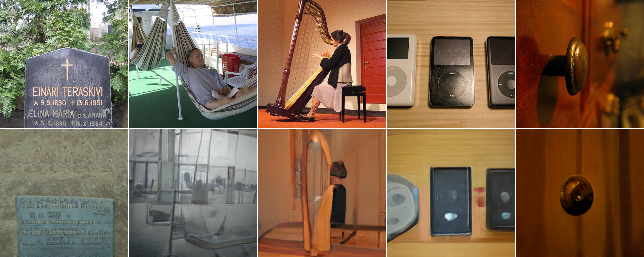

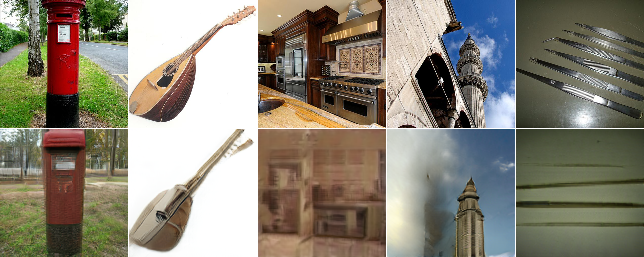

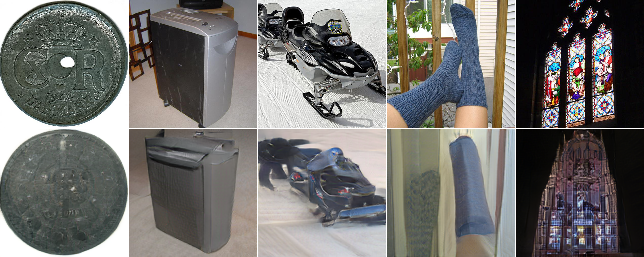

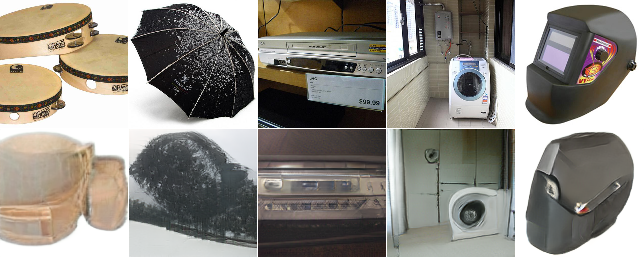

In [299]:
from PIL import Image
from research.scripts.bigbigan import *

splits = 10
cols = 50 // splits

out_path = 'X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\results'
name = 'biggan_result01_v3'

for i, (stim, target, pred) in enumerate(zip(np.split(x_stim, splits), np.split(x_target, splits), np.split(x_pred, splits))):
    out = np.concatenate([stim, target])
    img = imgrid(image_to_uint8(out), cols=cols)
    Image.fromarray(img).save(Path(out_path) / f'{name}_{i*cols}-{(i+1)*cols}.png')
    imshow(img)

In [167]:
y_embedding_pred = np.load('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\biggan-128__y_embedding__sub-03__test-prediction.npy')
y_embedding_pred = y_embedding_pred
y_pred = y_embedding_pred @ embedding_matrix_pinv

indices = y_pred.argsort(axis=1)
# y_pred[:, indices[:, -5:]]

y_pred = np.zeros((50, 1000))
y_pred[np.arange(50), indices[:, -1]] = 1.
y_pred.mean()

0.001

In [143]:
z_target.mean()

0.0014908611

In [290]:
# Get clip classes
import torch.nn.functional as F

derivatives = 'X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\'
clip_embedding = np.load(Path(derivatives) / 'ViT-B=32__embedding__sub-03__test-prediction__v2.npy')
zeroshot_weights  = torch.load('./zeroshot-weights/ViT-B=32-zeroshot-weights.pt').cpu().numpy()
print(clip_embedding.shape, zeroshot_weights.shape)
clip_embedding /= np.linalg.norm(clip_embedding, axis=-1, keepdims=True)
clip_y_pred = clip_embedding @ zeroshot_weights
clip_y_pred[:, 916] = 0
clip_y_pred = F.softmax(torch.from_numpy(clip_y_pred) * 500., dim=-1).numpy()

(50, 512) (512, 1000)


In [291]:
clip_y_pred.max(axis=1)

array([0.53461222, 0.97602991, 0.74290739, 0.66036821, 0.56724415,
       0.22813573, 0.44382343, 0.44445022, 0.91508315, 0.84371595,
       0.77981731, 0.27143076, 0.83495081, 0.99714762, 0.99203722,
       0.78277948, 0.93759004, 0.34753734, 0.75347512, 0.96400385,
       0.69839733, 0.95631946, 0.99364335, 0.45168404, 0.58628571,
       0.43102546, 0.36261421, 0.88138357, 0.61844056, 0.55004352,
       0.53797696, 0.45362958, 0.832745  , 0.35217325, 0.56767384,
       0.55571682, 0.91417578, 0.86919412, 0.51251908, 0.61853076,
       0.46071917, 0.33760548, 0.65736355, 0.94612749, 0.92923087,
       0.68777513, 0.39423696, 0.79724696, 0.58792218, 0.31249645])

In [292]:
clip_y_pred.argmax(axis=1)

array([902, 676, 902, 872, 801, 816, 676, 801, 676, 676, 801, 801, 801,
       801, 676, 902, 516, 872, 544, 516, 801, 801, 516, 516, 902, 544,
       801, 872, 516, 516, 516, 516, 872, 590, 516, 872, 902, 516, 516,
       516, 752, 516, 872, 872, 872, 446, 516, 590, 516, 516], dtype=int64)